In [0]:
# Identifying superclasses indexes
# Identifying superclasses indexes
import pandas as pd
#1 Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded1 = drive.CreateFile({'id':'1IfioWuWPLvvMvkdVCflMh5v6xVfKwBxW'}) # replace the id with id of file you want to access
downloaded1.GetContentFile('meta')

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
  
meta = unpickle('meta')
k=0
# Looping through the list to find the index of vehicle 1 and vehicle 2
for i in meta[b'coarse_label_names']:
  if i==b'vehicles_1':
    a = k
  if i==b'vehicles_2':
    b = k
  k=k+1  
print('Vehicle 1 index:',a,'\nVehicle 2 index:',b)
coarse = pd.DataFrame(meta[b'coarse_label_names'])
fine = pd.DataFrame(meta[b'fine_label_names'])

Vehicle 1 index: 18 
Vehicle 2 index: 19


## With Cifar-100 dataset in Keras

In [0]:
# install keras first
!pip install dill
!pip install -q keras

In [0]:
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"

In [0]:
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")

Using TensorFlow backend.


In [0]:
#batch_size = 1000
num_classes = 2
'''
epochs_longrun = 500
save_dir = "/work"
res_dir = "/results"
model_name = 'convnet_cifar100'
'''

'\nepochs_longrun = 500\nsave_dir = "/work"\nres_dir = "/results"\nmodel_name = \'convnet_cifar100\'\n'

In [0]:
from keras.datasets import cifar100

In [0]:
from __future__ import print_function
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.utils import to_categorical
from keras.models import load_model

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [0]:
def combinedf(x,y,z):
  # Required subset of data in dataframe
  x = x.reshape(x.shape[0],3*32*32)
  images_df = pd.DataFrame(x, columns = list(range(0,3072)))
  temp = pd.DataFrame(y, columns = ['Target'])
  sub = pd.DataFrame(z, columns = ['Subtar'])
  images_df = pd.concat([images_df,sub,temp],axis=1)
  vehicle_images = images_df[(images_df['Target']==18) | (images_df['Target']==19) ]
  vehicle_images['Subtar'] = fine[0][vehicle_images['Subtar']].values # Subtar holds the subclass values.
  vehicle_images['Target'] = coarse[0][vehicle_images['Target']].values # Taget holds the superclass values
  #vehicle_images.head()
  return vehicle_images

In [0]:

import tensorflow as tf
import numpy as np
from keras.utils import to_categorical
tf.reset_default_graph()
tf.set_random_seed(343)
np.random.seed(343)
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='coarse')
(a_train, b_train), (a_test, b_test) = cifar100.load_data(label_mode='fine')
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
trainset = combinedf(x_train,y_train,b_train)
testset  = combinedf(x_test,y_test,b_test)

x_train shape: (50000, 3, 32, 32)
50000 train samples
10000 test samples


In [0]:
data = pd.concat([trainset,testset],axis=0)

In [0]:
vehicle1 = np.unique(data[(data['Target']==b'vehicles_1')]['Subtar'])
vehicle1

array([b'bicycle', b'bus', b'motorcycle', b'pickup_truck', b'train'],
      dtype=object)

In [0]:
vehicle2 = np.unique(data[(data['Target']==b'vehicles_2')]['Subtar'])
vehicle2

array([b'lawn_mower', b'rocket', b'streetcar', b'tank', b'tractor'],
      dtype=object)

In [0]:
v1s1 = b'motorcycle'
v2s2 = b'lawn_mower'
v1s3 = b'pickup_truck'
v2s4 = b'tractor'

In [0]:
trainset = data[( (data['Subtar']!=v1s1) & (data['Subtar']!=v2s2) & (data['Subtar']!=v1s3) & (data['Subtar']!=v2s4)) ]
testset = data[( (data['Subtar']==v1s1) | (data['Subtar']==v2s2) ) | (data['Subtar']==v1s3) | (data['Subtar']==v2s4) ]

In [0]:
data[( (data['Subtar']!=v1s1) & (data['Subtar']!=v2s2) & (data['Subtar']!=v1s3) & (data['Subtar']!=v2s4))].shape

(3600, 3074)

In [0]:
X_train = trainset.drop(['Subtar','Target'],axis=1)
y_train = trainset['Target']
X_test = testset.drop(['Subtar','Target'],axis=1)
y_test = testset['Target']

In [0]:
#Normalize data
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

In [0]:
y_train = pd.get_dummies(y_train,drop_first=True)
y_test = pd.get_dummies(y_test,drop_first=True)

# CNN

In [0]:
from keras.utils import np_utils
# one hot encode outputs
y_train = to_categorical(y_train,num_classes=2)
y_test = to_categorical(y_test,num_classes=2)
num_classes = y_test.shape[1]

In [0]:
X_train = X_train.values
X_test = X_test.values

In [0]:

X_train = X_train.reshape(X_train.shape[0],3,32,32)
X_test = X_test.reshape(X_test.shape[0],3,32,32)

In [0]:
model3=Sequential()

model3.add(Conv2D(128, (3, 3), padding='same',input_shape=X_train.shape[1:]))
model3.add(Activation('relu'))
model3.add(Conv2D(128, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.20))

model3.add(Conv2D(256, (3, 3), padding='same'))
model3.add(Activation('relu'))
model3.add(Conv2D(256, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(512, (3, 3), padding='same'))
model3.add(Activation('relu'))
model3.add(Conv2D(512, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.5))

model3.add(Flatten())
model3.add(Dense(1024))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))
model3.add(Dense(2))
model3.add(Activation('softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 32, 32)       3584      
_________________________________________________________________
activation_1 (Activation)    (None, 128, 32, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 30, 30)       147584    
_________________________________________________________________
activation_2 (Activation)    (None, 128, 30, 30)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 15, 15)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 15, 15)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 15, 15)       295168    
__________

In [0]:
Best = 'Best'
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar100_%s_model.{epoch:03d}.h5' % Best
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)
callbacks = [checkpoint]

In [0]:
opt = Adam(lr=0.00005, decay=1e-6)

model3.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [0]:
print('Using real-time data augmentation.')

datagen = ImageDataGenerator(
	featurewise_center=False, 
	samplewise_center=False,  
	featurewise_std_normalization=False,
	samplewise_std_normalization=False, 
	zca_whitening=False, 
	rotation_range=0, 
	width_shift_range=0.1, 
	height_shift_range=0.1,
	horizontal_flip=True, 
	vertical_flip=False) 

datagen.fit(X_train)

Using real-time data augmentation.


In [0]:
#Let's train the model
epochs = 30
#batch_size=128
hist = model3.fit_generator(datagen.flow(X_train, y_train,
    batch_size=128),shuffle= True,
    steps_per_epoch=X_train.shape[0] // 256,
    epochs=epochs,
    validation_data=(X_test, y_test),
    workers=4,callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
14/14 [==============================] - 6s 453ms/step - loss: 0.6955 - acc: 0.4849 - val_loss: 0.6939 - val_acc: 0.5000

Epoch 00001: val_acc improved from -inf to 0.50000, saving model to /content/saved_models/cifar100_Best_model.001.h5
Epoch 2/30
14/14 [==============================] - 1s 89ms/step - loss: 0.6924 - acc: 0.5340 - val_loss: 0.6928 - val_acc: 0.5046

Epoch 00002: val_acc improved from 0.50000 to 0.50458, saving model to /content/saved_models/cifar100_Best_model.002.h5
Epoch 3/30
14/14 [==============================] - 2s 110ms/step - loss: 0.6920 - acc: 0.5244 - val_loss: 0.6924 - val_acc: 0.5050

Epoch 00003: val_acc improved from 0.50458 to 0.50500, saving model to /content/saved_models/cifar100_Best_model.003.h5
Epoch 4/30
14/14 [==============================] - 1s 90ms/step - loss: 0.6918 - acc: 0.5078 - val_loss: 0.6926 - val_acc: 0.4921

Epoch 00004: val_acc did not improve from 0.50500
Epoch 5/30
14/1

In [0]:
scores = model3.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 64.79%


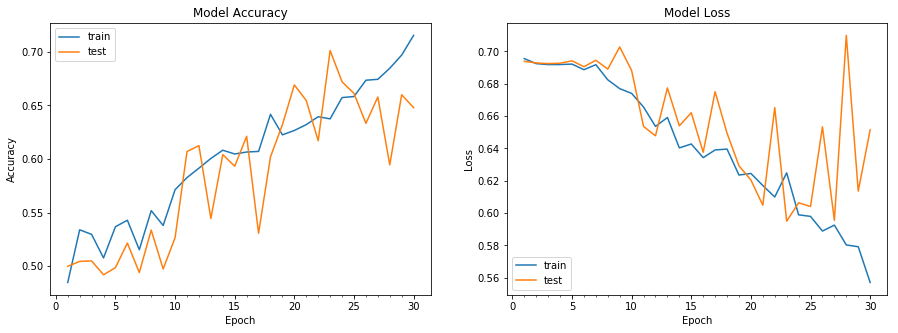

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'test'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'test'], loc='best')
    plt.show()
    
plot_model_history(hist)

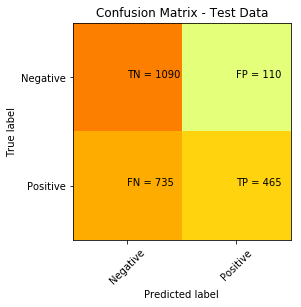

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model3.predict(X_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
  for j in range(2):
    plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [0]:
from sklearn.metrics import classification_report
cp = classification_report(np.argmax(y_test,axis=1),y_pred)
print(cp)

              precision    recall  f1-score   support

           0       0.60      0.91      0.72      1200
           1       0.81      0.39      0.52      1200

   micro avg       0.65      0.65      0.65      2400
   macro avg       0.70      0.65      0.62      2400
weighted avg       0.70      0.65      0.62      2400



In [0]:
#print out randomly selected images(black/red labl-->correct/wrong prediction )
def cifar_grid_c(X,Y,inds,n_col, predictions=None):
  if predictions is not None:
    if Y.shape != predictions.shape:
      print("Predictions must equal Y in length!")
      return(None)
  N = len(inds)
  n_row = int(ceil(1.0*N/n_col))
  fig, axes = plt.subplots(n_row,n_col,figsize=(10,10))
  
#  clabels = labels["label_names"]
  clabels = ['vehicles 1','vehicles 2']
  print(type(clabels))
  for j in range(n_row):
    for k in range(n_col):
      i_inds = (j*n_col)+k
      i_data = inds[i_inds]
      
     # axes[j][k].set_axis_off()
      if i_inds < N:
        rgb = X[[i_data,...]]
        #print(rgb.shape)
        img = rgb.reshape(3,32,32).transpose([1, 2, 0])
        axes[j][k].imshow(img, interpolation='nearest')
        label = clabels[np.argmax(Y[i_data,...])]
        axes[j][k].set_title(label)
        if predictions is not None:
          pred = clabels[np.argmax(predictions[i_data,...])]
          if label != pred:
            label += " n"
            axes[j][k].set_title(pred, color='red')            
  
  fig.set_tight_layout(True)

<class 'list'>


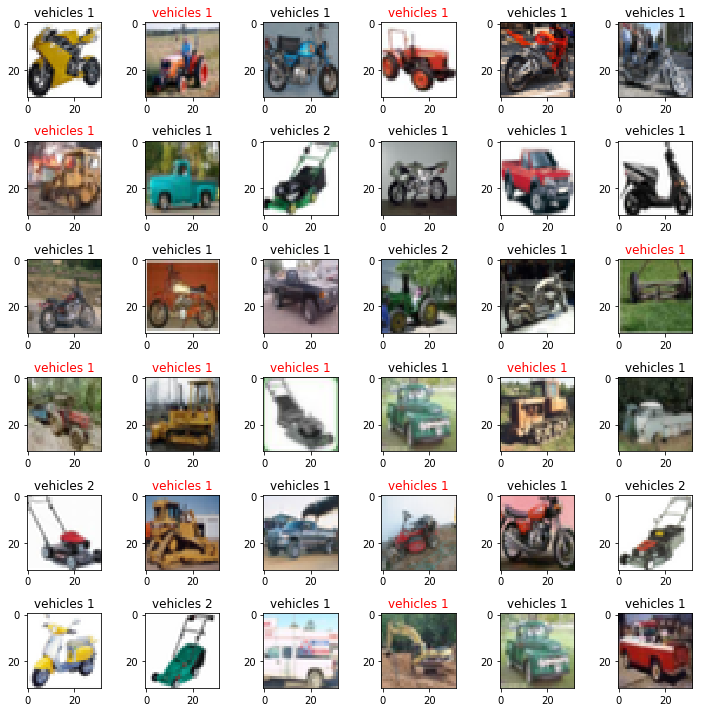

In [0]:
num_predictions = 36
predict_gen = model3.predict_generator(datagen.flow(X_test, y_test,
    batch_size=256, shuffle=False),
    steps=(X_test.shape[0] // 256)+1, workers=4)

indices = [np.random.choice(range(len(X_test))) 
           for i in range(num_predictions)]

cifar_grid_c(X_test,y_test,indices,6, predictions=predict_gen)